Loading needed population fields
Computing GW limiting thresholds
Computing GRB PROMPT limiting thresholds


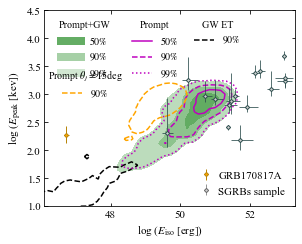

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D

# --- Plot style ---
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.figsize'] = (4.3, 3.5)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["axes.axisbelow"] = False

num = 1000000
eos = "SFHo"

# --- Load population subsets actually used ---
table = h5py.File('../horizons2/population/computed_population/bhns_%i_%s_z10_mass_spin_thv_GWFAST_ET.hdf5' %(num,eos),'r')

print("Loading needed population fields")
m_disk = table['m_disk'][()]
snr_ETT = table['snr_ETT'][()]
bol_fluence_prompt = table['bol_fluence_prompt'][()]
Eiso = table['Eiso'][()]
Epeak = table['Epeak'][()]
table.close()

# --- Weights (NOT fixed) ---
spin_prescription = 'Zero'  # solo per comporre il nome file dei pesi
with h5py.File(f'../horizons2/population/computed_population/weight/w_bhns_{eos}_{spin_prescription}_notfixed.hdf5', 'r') as table_w:
    C_mc      = table_w['C_mc'][()]
    C_mc_low  = table_w['C_mc_low'][()]
    C_mc_high = table_w['C_mc_high'][()]
    w         = table_w['w'][()]
    w_low     = table_w['w_low'][()]
    w_high    = table_w['w_high'][()]

# --- Detection thresholds ---
lim_snr    = 12
lim_prompt = 3.09e-7

print("Computing GW limiting thresholds")
gw_det = snr_ETT >= lim_snr

# choose jet angles (0 deg and 15 deg indices)
jet_angle     = 0
jet_angle_15  = 1

Eiso_15  = Eiso[:, jet_angle_15]
Epeak_15 = Epeak[:, jet_angle_15]
Eiso     = Eiso[:, jet_angle]
Epeak    = Epeak[:, jet_angle]

print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi    = bol_fluence_prompt[:, jet_angle]    >= lim_prompt
prompt_det_fermi_15 = bol_fluence_prompt[:, jet_angle_15] >= lim_prompt

# --- Plots ---
bins = 50
smooth = 1.0
mask = (m_disk > 1.e-5)

# GW contours (black, 10% and 100%)
H, xedges, yedges = np.histogram2d(
    np.log10(Eiso[mask]),
    np.log10(Epeak[mask]),
    weights=(w * gw_det)[mask],
    bins=bins, range=[[45., 53.], [0., 4.]]
)
g  = gf(H, smooth)
gr = g.ravel()
s  = np.argsort(gr)
cr = np.empty_like(gr)
cr[s] = np.cumsum(gr[s])
c  = np.reshape(cr / cr.max(), g.shape)
xcentre = 0.5 * (xedges[:-1] + xedges[1:])
ycentre = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contour(X, Y, c, levels=[0.1, 1.0], colors="black", linestyles="--", linewidths=1.5)

# FERMI (magenta, 1–10–50%)
H, xedges, yedges = np.histogram2d(
    np.log10(Eiso[mask]),
    np.log10(Epeak[mask]),
    weights=(w * prompt_det_fermi)[mask],
    bins=bins, range=[[45., 53.], [0., 4.]]
)
g  = gf(H, smooth)
gr = g.ravel(); s = np.argsort(gr)
cr = np.empty_like(gr); cr[s] = np.cumsum(gr[s])
c  = np.reshape(cr / cr.max(), g.shape)
xcentre = 0.5 * (xedges[:-1] + xedges[1:])
ycentre = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contour(X, Y, c, levels=[0.01, 0.1, 0.5], colors="m", linestyles=[':', '--', '-'], linewidths=1.5)

# FERMI 15 deg (orange, 10%)
H, xedges, yedges = np.histogram2d(
    np.log10(Eiso_15[mask]),
    np.log10(Epeak_15[mask]),
    weights=(w * prompt_det_fermi_15)[mask],
    bins=bins, range=[[45., 53.], [0., 4.]]
)
g  = gf(H, smooth)
gr = g.ravel(); s = np.argsort(gr)
cr = np.empty_like(gr); cr[s] = np.cumsum(gr[s])
c  = np.reshape(cr / cr.max(), g.shape)
xcentre = 0.5 * (xedges[:-1] + xedges[1:])
ycentre = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contour(X, Y, c, levels=[0.1], colors="orange", linestyles='--', linewidths=1.5)

# GW + FERMI (filled green, 1–10–50%)
H, xedges, yedges = np.histogram2d(
    np.log10(Eiso[mask]),
    np.log10(Epeak[mask]),
    weights=(w * prompt_det_fermi * gw_det)[mask],
    bins=bins, range=[[45., 53.], [0., 4.]]
)
g  = gf(H, smooth)
gr = g.ravel(); s = np.argsort(gr)
cr = np.empty_like(gr); cr[s] = np.cumsum(gr[s])
c  = np.reshape(cr / cr.max(), g.shape)
xcentre = 0.5 * (xedges[:-1] + xedges[1:])
ycentre = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
plt.contourf(X, Y, c, levels=[0.01, 1.], colors="forestgreen", alpha=.3)
plt.contourf(X, Y, c, levels=[0.1, 1.], colors="forestgreen", alpha=.3)
plt.contourf(X, Y, c, levels=[0.5, 1.], colors="forestgreen", alpha=.4)

# SGRB sample points with errors
Lsamples  = np.load('grb_data/GBM_BAT_SGRB_spec_or_photoz_L_samples.npy')
Epsamples = np.load('grb_data/GBM_BAT_SGRB_spec_or_photoz_Ep_samples.npy')
SGRBs = {
    'Liso': np.median(Lsamples[:-1], axis=1),
    'Liso_err_low':  np.median(Lsamples[:-1], axis=1) - np.percentile(Lsamples[:-1], 5.,  axis=1),
    'Liso_err_high':-np.median(Lsamples[:-1], axis=1) + np.percentile(Lsamples[:-1], 95., axis=1),
    'Ep': np.median(Epsamples[:-1], axis=1),
    'Ep_err_low':  np.median(Epsamples[:-1], axis=1) - np.percentile(Epsamples[:-1], 5.,  axis=1),
    'Ep_err_high':-np.median(Epsamples[:-1], axis=1) + np.percentile(Epsamples[:-1], 95., axis=1)
}
flux_fact = [2,2.72,0.89,2.60,1.4925,1.39,1.89,1.45,2.18,1.81,1.84,1.84,1.84,1.84,1.84,1.84]
time      = [0.96,0.96,0.256,0.176,0.24,0.432,0.256,1.152,1.088,1.728,0.896,0.256,1.152,1.44,0.144,0.96]
SGRBs['Liso']         = (SGRBs['Liso']        / flux_fact) * time
SGRBs['Liso_err_low'] = (SGRBs['Liso_err_low']/ flux_fact) * time
SGRBs['Liso_err_high']= (SGRBs['Liso_err_high']/flux_fact) * time
yerr = (np.log10(1.+(SGRBs['Ep_err_low']/SGRBs['Ep'])),
        np.log10(1.+(SGRBs['Ep_err_high']/SGRBs['Ep'])))
xerr = (np.log10(1.+(SGRBs['Liso_err_low']/SGRBs['Liso'])),
        np.log10(1.+(SGRBs['Liso_err_high']/SGRBs['Liso'])))
plt.errorbar(np.log10(SGRBs['Liso']), np.log10(SGRBs['Ep']),
             xerr=xerr, yerr=yerr, ls='None', marker='D',
             color='darkslategrey', elinewidth=0.8, markersize=3.,
             markerfacecolor="lightgrey", alpha=0.99, zorder=3)

# GRB170817A point
Eiso_grb170817a = 5.3e46  # erg
Eiso_err_grb170817a = 1.e46
Epeak_grb170817a = 185    # keV
Epeak_err_grb170817a = 78
plt.errorbar(np.log10(Eiso_grb170817a), np.log10(Epeak_grb170817a),
             xerr=np.log10(1.+(Eiso_err_grb170817a/Eiso_grb170817a)),
             yerr=np.log10(1.+(Epeak_err_grb170817a/Epeak_grb170817a)),
             marker='D', ls='None', color='darkgoldenrod',
             markerfacecolor="orange", elinewidth=1., markersize=3., zorder=3)

# Labels and legends
plt.xlabel(r'log ($E_\mathrm{iso}$ [erg])', size=11)
plt.ylabel(r'log ($E_\mathrm{peak}$ [kev])', size=11)
plt.tick_params(direction='in', left=True, bottom=True, top=True, right=True, labelsize=11)

leg1 = plt.legend([Line2D([0],[0],color='m'),
                   Line2D([0],[0],color='m',ls="--"),
                   Line2D([0],[0],color='m',ls=":")],
                  [r'$50\%$', r'$90\%$', r'$99\%$'],
                  bbox_to_anchor=(0.57, 0.999), title="Prompt",
                  title_fontsize=10, prop={'size': 10}, frameon=False)
leg2 = plt.legend([Line2D([0],[0],color='forestgreen',lw=8,alpha=0.7),
                   Line2D([0],[0],color="forestgreen",lw=8,alpha=0.4),
                   Line2D([0],[0],color='forestgreen',lw=8,alpha=0.2)],
                  [r'$50\%$', r'$90\%$', r'$99\%$'],
                  bbox_to_anchor=(0.3, 0.999), title="Prompt+GW",
                  title_fontsize=10, prop={'size': 10}, frameon=False)
leg3 = plt.legend([Line2D([0],[0],color='black',ls="--")],
                  [r'$90\%$'],
                  bbox_to_anchor=(0.82, 0.999), title="GW ET",
                  title_fontsize=10, prop={'size': 10}, frameon=False)
leg4 = plt.legend([Line2D([0],[0],color='orange',ls="--")],
                  [r'$90\%$'],
                  bbox_to_anchor=(0.35, 0.5),
                  title=r"Prompt $\theta_j=15$deg",
                  title_fontsize=10, prop={'size': 10}, frameon=False)
plt.gca().add_artist(leg1); plt.gca().add_artist(leg2)
plt.gca().add_artist(leg3); plt.gca().add_artist(leg4)

plt.errorbar(100,100,yerr=1000,marker='D',ls='None',color='darkgoldenrod',
             markerfacecolor='orange', elinewidth=1., markersize=3., label="GRB170817A")
plt.errorbar(100,100,yerr=1000,marker='D',ls='None',color="dimgrey",
             elinewidth=0.7, markersize=3., markerfacecolor="lightgrey", alpha=0.99,
             label="SGRBs sample")
plt.legend(loc=4, prop={'size': 11}, frameon=False, handletextpad=0.1)

plt.xlim(46.1, 53.3)
plt.ylim(1., 4.5)
plt.show()
